In [1]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow import keras
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF

In [2]:
df = pd.read_csv('File_reference.csv')
#df = df[['Sample', 'Label', 'Features_2classes']]
print(df.shape)
df.head(-10)

(1198, 13)


,Sample,Time (week),File name,Total pixel,Time_perf,%_to_1st,Group,Label,pred,Features_2classes,Kmeans_4,Pred_4groups,Group5
0,236LT,1,236LT_w1.nii.gz,49381,0,1.000000,0,0,0,"(0.8123992, 0.8109689, 0.17166863, 0.9642391, ...",3.0,0,0
1,236LT,2,236LT_w2.nii.gz,54932,0,1.000000,0,0,0,"(0.8048926, 0.8474441, 0.18427639, 0.9516808, ...",3.0,0,0
2,236LT,3,236LT_w3.nii.gz,55992,0,1.000000,0,0,0,"(0.8396998, 0.8261546, 0.19749181, 0.9547946, ...",3.0,0,0
3,236LT,4,236LT_w4.nii.gz,56592,0,1.000000,0,0,0,"(0.8376477, 0.8101227, 0.19923699, 0.90740865,...",3.0,0,0
4,236RT,1,236RT_w1.nii.gz,51833,0,1.000000,0,0,0,"(0.60956246, 1.0117139, 0.11942516, 1.251376, ...",1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,M92LT,2,M92LT_w2.nii.gz,60363,0,1.000000,0,0,0,"(0.8280396, 0.76578206, 0.20481256, 0.88005775...",1.0,0,1
1184,M92LT,3,M92LT_w3.nii.gz,65541,1,1.000000,1,1,1,"(0.88680106, 0.46828765, 1.0988641, 0.38582915...",2.0,1,2
1185,M92LT,4,M92LT_w4.nii.gz,39387,2,0.600952,2,1,1,"(0.46542335, 0.6181741, 2.898242, 0.59221977, ...",0.0,2,3
1186,M92RT,1,M92RT_w1.nii.gz,56111,0,1.000000,0,0,0,"(1.0869201, 0.50709945, 0.48206553, 0.45642927...",1.0,0,0


In [3]:
# Only include samples with no less than 3 observations
count_df = df.groupby('Sample').count()
count_df = count_df[count_df['Label'] >= 3]
print(count_df.shape)
count_df.head()

(261, 12)


,Time (week),File name,Total pixel,Time_perf,%_to_1st,Group,Label,pred,Features_2classes,Kmeans_4,Pred_4groups,Group5
Sample,,,,,,,,,,,,
236LT,4,4,4,4,4,4,4,4,4,4,4,4
236RT,4,4,4,4,4,4,4,4,4,4,4,4
238LT,4,4,4,4,4,4,4,4,4,4,4,4
238RT,4,4,4,4,4,4,4,4,4,4,4,4
239LT,3,3,3,3,3,3,3,3,3,3,3,3


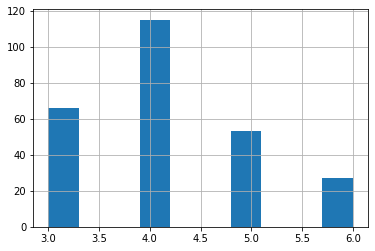

In [4]:
count_df['Label'].hist()

In [5]:
sample_num = count_df.shape[0]
max_seq_len = max(count_df['Label'].values)
feature_num = 128
Group_num = np.unique(df['Label'].values).shape[0]
print(Group_num)

2


In [6]:
x_np = np.zeros(shape =(sample_num, max_seq_len-1, feature_num), dtype = np.float32)
y_np = np.zeros(shape =(sample_num, max_seq_len-1), dtype = np.int32)
y_oh = np.zeros(shape =(sample_num, max_seq_len-1, Group_num), dtype = np.float32)
y_ls = []
x_ls = []

RNN_input_file = {'Sample':[], 'File':[], 'Label':[], 'Group':[] }

for idx, (sample, row) in enumerate(count_df.iterrows()):
    seq_length = row['Label']
    temp_df = df[df['Sample'] == sample].reset_index()
    label = []
    f = []
    file_ls = []
    group = []
    
    for t in range(seq_length - 1):
        # label starts from t+1, features stop at seq_length -1
        label_t_plus = temp_df.loc[t+1, 'Label']
        group_t_plus = temp_df.loc[t+1, 'Group']
        features = temp_df.loc[t, 'Features_2classes']
        features = np.array(features[1:-1].split(', '), dtype = np.float32)
        
        label.append(label_t_plus)
        group.append(group_t_plus)
        file_ls.append(temp_df.loc[t, 'File name'])
        f.append(features)
        
        x_np[idx, t, :] = features
        y_oh[idx, t, int(label_t_plus)] = 1.0
        y_np[idx, t] = int(label_t_plus)
    
    x_ls.append(f)
    y_ls.append(label)
    RNN_input_file['Sample'].append(sample)
    RNN_input_file['Label'].append(label)
    RNN_input_file['Group'].append(tuple(group))
    RNN_input_file['File'].append(tuple(file_ls))
        
print('check X value:\n {}'.format(x_np[0, :, :4]))
print('check y value: {}'.format(y_np[0]))
print('check shape of x: {}'.format(x_np.shape))
print('check one hot y: {}'.format(y_oh[0]))
print('check y: {}'.format(y_np[0]))

check X value:
 [[0.8123992  0.8109689  0.17166863 0.9642391 ]
 [0.8048926  0.8474441  0.18427639 0.9516808 ]
 [0.8396998  0.8261546  0.19749181 0.9547946 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
check y value: [0 0 0 0 0]
check shape of x: (261, 5, 128)
check one hot y: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]]
check y: [0 0 0 0 0]


In [7]:
RNN_input_file = pd.DataFrame(RNN_input_file)
RNN_input_file.head()
RNN_input_file.to_csv('CRNN_file_reference.csv', index = False)

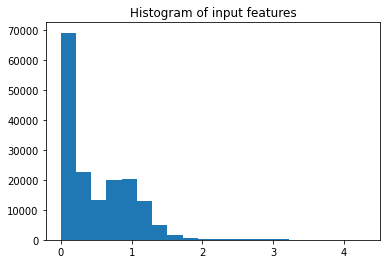

In [7]:
hist, bins = np.histogram(x_np, bins = np.histogram_bin_edges(x_np, bins = 20))
plt.figure()
plt.hist(x_np.flatten(), bins = bins)
plt.title('Histogram of input features')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
# split data into training set and test set by a ratio of 8:2
train_f, test_f, train_l, test_l = train_test_split(
        x_np, y_oh, test_size=0.2, random_state=41)
#del imgs
# split test data into validation and evaluation evenly
val_f, evl_f, val_l, evl_l = train_test_split(
        test_f, test_l, test_size = 0.5, random_state=44)
#del test_img

print('Shape of train data: {}'.format(train_f.shape))
print('Shape of validation data: {}'.format(val_f.shape))
print('Shape of evaluation data: {}'.format(evl_f.shape))
print('Total number of perforated in train data: {}'.format(np.count_nonzero(train_l[:, :, 1:])))
print('Total number of perforated in validation data: {}'.format(np.count_nonzero(val_l[:, :, 1:])))
print('Total number of perforated in evaluation data: {}'.format(np.count_nonzero(evl_l[:, :, 1:])))

def read_dataset(imgs, labels, batch_size=8,shuffle_size=224):
    
    dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))
    dataset = dataset.shuffle(shuffle_size).batch(batch_size)
    dataset = dataset.repeat()
    
    return dataset.prefetch(tf.data.experimental.AUTOTUNE) 

train_set = read_dataset(train_f, train_l, 40, shuffle_size = 200)
val_set = read_dataset(val_f, val_l, 10, shuffle_size = 20)
evl_set = read_dataset(evl_f, evl_l, 10, shuffle_size = 20)

Shape of train data: (208, 5, 128)
Shape of validation data: (26, 5, 128)
Shape of evaluation data: (27, 5, 128)
Total number of perforated in train data: 205
Total number of perforated in validation data: 24
Total number of perforated in evaluation data: 23


In [9]:
for item in evl_set.take(3):
    print(item[0].shape, item[1].shape)

(10, 5, 128) (10, 5, 2)
(10, 5, 128) (10, 5, 2)
(7, 5, 128) (7, 5, 2)


#### Use Generator for data.dataset

In [10]:
from sklearn.model_selection import train_test_split
train_f, test_f, train_l, test_l = train_test_split(
        x_ls, y_ls, test_size=0.2, random_state=41)
#del imgs
# split test data into validation and evaluation evenly
val_f, evl_f, val_l, evl_l = train_test_split(
        test_f, test_l, test_size = 0.5, random_state=44)

In [11]:
def reader_generator(features, labels):
    def generator():
        for x, y in zip(features, labels):
            yield x, y
            
    return generator

def reader(features, labels, shuffle_size, batch_size):
    file_generator = reader_generator(features, labels)
    dataset = tf.data.Dataset.from_generator(file_generator, 
                        output_types = (tf.float32, tf.float32),
                        output_shapes = (tf.TensorShape((None, 128)), tf.TensorShape((None,))))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(shuffle_size).batch(batch_size)
    return dataset.prefetch(tf.data.experimental.AUTOTUNE)

train_set = reader(train_f, train_l, 100, 1)
val_set = reader(val_f, val_l, 20, 1)
evl_set = reader(evl_f, evl_l, 20, 1)

In [12]:
for line in train_set.take(2):
    print(line[0].shape.as_list(), line[1].shape.as_list())

[1, 3, 128] [1, 3]
[1, 2, 128] [1, 2]


In [35]:
# build model
model = keras.Sequential([
    keras.layers.Masking(mask_value = 0.),
    keras.layers.BatchNormalization(),
    keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences= True, dropout = 0.2, recurrent_dropout = 0.2)),
    keras.layers.Dropout(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences= True, dropout = 0.2, recurrent_dropout = 0.2)), 
    keras.layers.Dropout(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences= True, dropout = 0.2, recurrent_dropout = 0.2)), 
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation = "relu"),
    keras.layers.Dense(2, activation = "softmax")]
)
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")
model.compile(optimizer = optimizer,
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy']
             )

#dropout = 0.5, recurrent_dropout = 0.5,

In [36]:
model.build(input_shape = (1,3,128))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          multiple                  0         
_________________________________________________________________
batch_normalization_4 (Batch multiple                  512       
_________________________________________________________________
bidirectional_12 (Bidirectio multiple                  788480    
_________________________________________________________________
dropout_12 (Dropout)         multiple                  0         
_________________________________________________________________
bidirectional_13 (Bidirectio multiple                  656384    
_________________________________________________________________
dropout_13 (Dropout)         multiple                  0         
_________________________________________________________________
bidirectional_14 (Bidirectio multiple                 

In [37]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./my_logs/my_logsBidirctional_Two_Classes_RNN_{epoch}.h5", 
                                                monitor = 'val_loss', mode = 'min',
                                                save_best_only=True)

class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f} \n".format(logs["val_loss"] / logs["loss"]))

root_logdir = os.path.join(os.curdir, "./my_logs/Bidirctional_Two_Classes_RNN")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir) 

plotlosses = PlotLossesKerasTF()
callbacks = [checkpoint_cb, PrintValTrainRatioCallback(), tensorboard_cb, plotlosses]

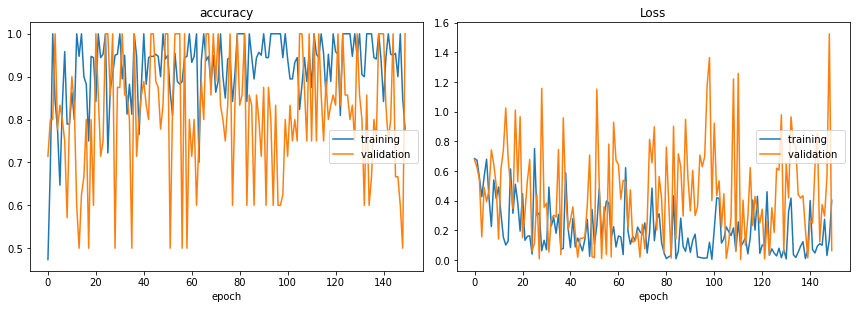

accuracy
	training         	 (min:    0.000, max:    1.000, cur:    0.778)
	validation       	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.005, max:    0.752, cur:    0.403)
	validation       	 (min:    0.004, max:    1.525, cur:    0.064)
6/6 [==============================] - 0s 71ms/step - loss: 0.4035 - accuracy: 0.7778 - val_loss: 0.0639 - val_accuracy: 1.0000


In [38]:
history = model.fit(train_set, steps_per_epoch= 6, epochs=150, 
            validation_data=val_set,
            validation_steps=2,
            callbacks=callbacks)

In [52]:
model= keras.models.load_model('./my_logs/my_logsBidirctional_Two_Classes_RNN_25.h5')
model.evaluate(evl_set, steps = 20)

20/20 [==============================] - 1s 54ms/step - loss: 0.3058 - accuracy: 0.9298


[0.3058047422207892, 0.9298246]

In [67]:
correct_count = 0
wrong_count = 0
pred_bi = []
pred_y = []
for x, y in zip(x_ls, y_ls):
    x = np.array(x)
    x = x[np.newaxis, :, :]
    pred = model.predict_classes(np.array(x))
    print("Predicted is : {}    ; True label is: {}    ;".format(np.squeeze(pred), np.array(y)))
    print()
    a = all(np.squeeze(pred) == np.array(y))
    pred_bi.append(a)
    pred_y.append(np.squeeze(pred))
    if a:
        correct_count += 1
    else:
        wrong_count += 1

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0]    ; True label is: [0 0]    ;

Predicted is : [0 0]    ; True label is: [0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 1]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label 

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 1 1]    ; True label is: [0 1 1]    ;

Predicted is : [1 1 1 1]    ; True label is: [0 1 1 1]    ;

Predicted is : [0 0 0 0]    ; True label is: [0 0 0 0]    ;

Predicted is : [0 0 0 0 0]    ; True label is: [0 0 0 0 1]    ;

Predicted is : [0 0 1 1]    ; True label is: [0 0 1 1]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted i

In [68]:
print(correct_count)
print(wrong_count)
print(correct_count / (wrong_count + correct_count))

192
69
0.735632183908046


In [70]:
transit_points = []
for y in y_ls:
    y = np.array(y)
    trans = 1
    for idx, j in enumerate(y):
        if j == 0:
            trans += 1
        elif j == 1:
            continue
            
        if idx == (y.shape[0] - 1) and j == 0:
            trans = 'Infinity'
            
    transit_points.append(str(trans))
    print(y, trans)

[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0] Infinity
[0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 1] 3
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0] Infinity
[0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[0 1] 2
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[0 1 1] 2
[0 1] 2
[0 1] 2
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[0 1 1] 2
[0 1] 2
[1 1] 1
[0 0] Infinity
[1 1] 1
[0 0] Infinity
[0 0 1] 3
[0 0 1] 3
[1 1 1] 1
[0 0 1] 3
[1 1] 1
[0 1] 2
[0 0 0] Infinity
[0 0 1] 3
[0 0 1] 3
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Inf

In [71]:
acc_df = pd.DataFrame()
acc_df['Transition_point'] = transit_points
acc_df['y_True'] = y_ls
acc_df['y_pred'] = pred_y
acc_df['T/F'] = pred_bi

In [74]:
acc_df.head(-20)

,Transition_point,y_True,y_pred,T/F
0,Infinity,"[0, 0, 0]","[0, 0, 0]",True
1,Infinity,"[0, 0, 0]","[0, 0, 0]",True
2,Infinity,"[0, 0, 0]","[0, 0, 0]",True
3,Infinity,"[0, 0, 0]","[0, 0, 0]",True
4,Infinity,"[0, 0]","[0, 0]",True
...,...,...,...,...
236,Infinity,"[0, 0]","[0, 0]",True
237,4,"[0, 0, 0, 1]","[0, 0, 0, 0]",False
238,3,"[0, 0, 1, 1]","[0, 0, 0, 1]",False
239,2,"[0, 1, 1, 1]","[1, 1, 1, 1]",False


In [82]:
acc_df[['Transition_point','T/F']].groupby('Transition_point').mean()

,T/F
Transition_point,
1,0.916667
2,0.352941
3,0.228571
4,0.000000
5,0.250000
Infinity,1.000000


In [83]:
acc_df[['Transition_point','T/F']].groupby('Transition_point').count()

,T/F
Transition_point,
1,36
2,51
3,35
4,3
5,4
Infinity,132


In [84]:
df1 = acc_df[['Transition_point','T/F']].groupby('Transition_point').count()

In [85]:
df1.columns

Index(['T/F'], dtype='object')